Mount Google Drive and sync with GitHub repository. https://zerowithdot.com/colab-github-workflow/

In [3]:
from google.colab import drive
from os.path import join

GIT_USERNAME = "jthetzel"
# GIT_TOKEN = "XXX"   
GIT_REPOSITORY = "practical-deep-learning-for-coders"
ROOT = '/content/drive'     # default for the drive
PROJ = f'My Drive/fastai/{GIT_REPOSITORY}'       # path to your project on Drive
PROJECT_PATH = join(ROOT, PROJ)
GIT_PATH = f"https://github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git"

drive.mount(ROOT)           # we mount the drive at /content/drive

!mkdir -p "{PROJECT_PATH}"
!git clone "{GIT_PATH}" "{PROJECT_PATH}" 2> /dev/null || git -C "{PROJECT_PATH}" pull
!rsync -aP --exclude=data/ --exclude=.git/ "{PROJECT_PATH}"/  ./


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 2), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/jthetzel/practical-deep-learning-for-coders
   c3bfa2b..feaa208  master     -> origin/master
Updating c3bfa2b..feaa208
Fast-forward
 datasets/black.csv   | 100 ++++++++++++++++++++++++++
 datasets/grizzly.csv | 100 ++++++++++++++++++++++++++
 datasets/teddy.csv   | 200 +++++++++++++++++++++++++++++++++++++++++++++++++++
 3 files changed, 400 insertions(+)
 create mode 100644 datasets/black.csv
 create mode 100644 datasets/grizzly.csv
 create mode 100644 datasets/teddy.csv
sending incremental file list
./
datasets/
datasets/black.csv
          8,579 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=7/17)
datasets/griz

Creating your own dataset from Google Images

In [0]:
!pip install ipywidgets

In [0]:
from fastai.vision import *

We deviate from the canonical notebook to automate downloading all bear classes

In [0]:
classes = ['black', 'teddy', 'grizzly']

In [7]:
for item in classes:
  print(item)
  folder = f'{item}'
  file = f'datasets/{item}.csv'
  path = Path(f'data/{item}')
  path.mkdir(parents=True, exist_ok=True)
  download_images(file, path, max_pics=200)
  verify_images(path, delete=True, max_size=500)

black


teddy


Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

grizzly


In [0]:
path = 'data'

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes

['black', 'grizzly', 'teddy']

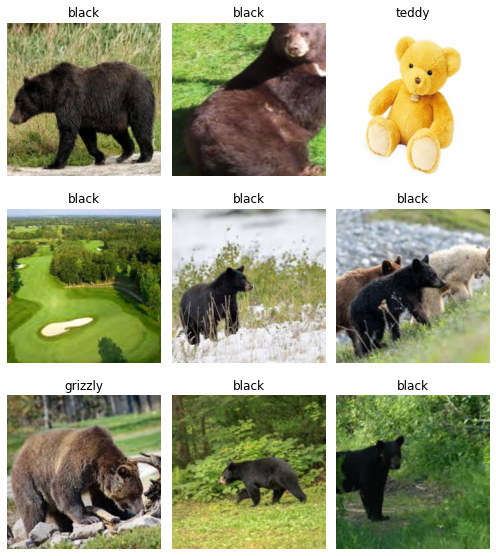

In [10]:
data.show_batch(rows=3, figsize=(7,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddy'], 3, 256, 64)

Train

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.327059,0.115957,0.062500,00:03
1,0.711194,0.059884,0.031250,00:02
2,0.484600,0.026609,0.000000,00:02
3,0.366832,0.013094,0.000000,00:02


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


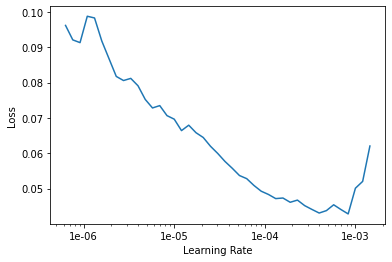

In [17]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.098337,0.005684,0.000000,00:03
1,0.062921,0.004094,0.000000,00:03


In [0]:
learn.save('stage-2')

Interpretation

In [0]:
learn.load('stage-2');

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

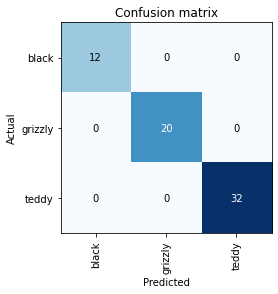

In [22]:
interp.plot_confusion_matrix()

Cleaning up

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [27]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [0]:
ImageCleaner(ds, idxs, path)